# Chaya Chandana

#Densenet

# Mount Google Drive

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/gwu-machine_learning_I-main/'

# Get the absolute path of the deep utilities folder
abspath_util_deep = '/content/drive/My Drive/Colab Notebooks/gwu-machine_learning_I-main/code/utilities/p3_deep_learning/'

Mounted at /content/drive


# Import Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import densenet121
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Dataset Path and Device Configuration

In [3]:
# Dataset path (update if needed)
root_path = '/content/drive/My Drive/Colab Notebooks/gwu-machine_learning_I-main/dataset/'  # Ensure the dataset is uploaded here

# Check dataset existence
if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Warning

In [4]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## TensorFlow

In [6]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Random seed

In [7]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

## Data Preprocessing

In [8]:
# Change working directory to the absolute path of the deep utilities folder
%cd $abspath_util_deep

# Import the deep utitilities
%run pmlm_utilities_deep.ipynb

/content/drive/My Drive/Colab Notebooks/gwu-machine_learning_I-main/code/utilities/p3_deep_learning


## Loading the data

## Creating the directory for the data


In [9]:
import os

# Make directory
directory = os.path.dirname(abspath_curr + '/dataset/')
if not os.path.exists(directory):
    os.makedirs(directory)

## Downloading the data to the directory

In [10]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=abspath_curr + '/dataset/',
    image_size=(224, 224),  # Resize images to 224x224
    batch_size=1,  # Load one image at a time to count total images
    label_mode='int',  # Labels are returned as integers
    shuffle=True  # Shuffle the dataset before splitting
)
print("\nThe length of the dataset is ", len(dataset))

Found 6862 files belonging to 11 classes.

The length of the dataset is  6862


## Getting the name of the target

In [11]:
target = 'label'

## Getting the info

In [12]:
# Display class names

classes = dataset.class_names

print(classes)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [13]:
# Get the number of classes
n_classes = len(classes)

# Print the number of classes
len(classes)

11

## Getting the training, validation and test data

In [14]:
# Get the total number of images
total_size = len(dataset)

print(total_size)

6862


In [15]:
# Calculate the sizes for Train (70%), Validation (15%), and Test (15%)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # The remaining 15%

# Split the dataset using random_split
data_train = dataset.take(train_size)
data_rest = dataset.skip(train_size)
data_valid = data_rest.take(val_size)
data_test = data_rest.skip(val_size)

In [16]:
# Print the sizes of each split
print(f"Total images: {total_size}")
print(f"Train size: {len(data_train)}")
print(f"Validation size: {len(data_valid)}")
print(f"Test size: {len(data_test)}")

Total images: 6862
Train size: 4803
Validation size: 1029
Test size: 1030


In [17]:
#  Re-laoding dataset with batch size (32)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=abspath_curr + '/dataset/',
    image_size=(224, 224),
    batch_size=32,  # Use batch size of 32 for training
    label_mode='int',  # Labels are returned as integers
    shuffle=True  # Shuffle the dataset
)
print("\nThe length of the dataset is ", len(dataset))

Found 6862 files belonging to 11 classes.

The length of the dataset is  215


## Data Augmentation and DataLoader

In [18]:
# Data Augmentation and Normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(20, shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # DenseNet normalization
])

# Load Dataset
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

# Train-Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Loading the data

In [19]:
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

## Getting the Name of the Target

In [32]:
import os
# Assuming the dataset is stored in a directory with subfolders as class names
data_dir = '/content/drive/My Drive/Colab Notebooks/gwu-machine_learning_I-main/dataset/'  # Update this path as needed
class_names = os.listdir(data_dir)
print(f"Class Names: {class_names}")

Class Names: ['snow', 'dew', 'fogsmog', 'rain', 'rainbow', 'frost', 'sandstorm', 'rime', 'glaze', 'hail', 'lightning']


## Getting Information About the Dataset

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Basic information about dataset
image_generator = ImageDataGenerator(validation_split=0.2)
data_iterator = image_generator.flow_from_directory(data_dir, target_size=(256, 256), batch_size=32)

print(f"Number of classes: {len(data_iterator.class_indices)}")
print(f"Class indices: {data_iterator.class_indices}")

Found 6862 images belonging to 11 classes.
Number of classes: 11
Class indices: {'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


## Loading Training, Validation, and Test Data

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_size = (256, 256)

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = train_gen.flow_from_directory(data_dir, target_size=image_size, batch_size=batch_size, subset='training', shuffle=True)
val_data = train_gen.flow_from_directory(data_dir, target_size=image_size, batch_size=batch_size, subset='validation', shuffle=False)

# Assuming a separate test dataset
test_dir = '/content/drive/My Drive/Colab Notebooks/gwu-machine_learning_I-main/dataset/'  # Update this path if necessary
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, shuffle=False)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.
Found 6862 images belonging to 11 classes.


## Preprocessing the Data Using Pretrained Model

In [35]:
from tensorflow.keras.applications import mobilenet_v2

# Update the preprocessing function for MobileNetV2
preprocess_input = mobilenet_v2.preprocess_input

# Apply preprocessing to all data generators
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
train_data = train_gen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='training',
    shuffle=True
)

val_data = train_gen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.
Found 6862 images belonging to 11 classes.


## Shuffling, Batching, and Prefetching the Data

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2

# Convert DirectoryIterator to tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(class_names)), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(class_names)), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(class_names)), dtype=tf.float32)
    )
)

# Shuffle, batch, and prefetch the data
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Ensure data generators are using MobileNetV2 preprocessing
preprocess_input = mobilenet_v2.preprocess_input

# Data generators already apply `preprocess_input` during `flow_from_directory`

## Training: Creating a Directory for the Model

In [36]:
import os

model_dir = '/content/models'
os.makedirs(model_dir, exist_ok=True)
print(f"Model directory created: {model_dir}")

Model directory created: /content/models


In [37]:
num_classes = len(class_names)  # Number of classes in the dataset
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 11


## Building the Architecture of the Model

In [38]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV2 base model
base_model = MobileNetV2(include_top=False, input_shape=(256, 256, 3), weights='imagenet')

# Freeze the base model's layers if transfer learning
base_model.trainable = False

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D instead of Flatten for MobileNetV2
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

# Update the output layer to match the number of classes in the dataset
num_classes = len(class_names)  # Ensure this matches your dataset
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Print model summary
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,919,499 (11.14 MB)

 Trainable params: 661,515 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


## Freezing the Pretrained Layers

In [39]:
for layer in base_model.layers:
    layer.trainable = False

## Setting Callbacks

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model using .keras format
checkpoint = ModelCheckpoint(filepath=f'{model_dir}/best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Compiling the Model

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the Model

In [42]:
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[checkpoint, early_stopping])

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1130s 6s/step - accuracy: 0.6191 - loss: 1.1761 - val_accuracy: 0.8371 - val_loss: 0.4678
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 86s 275ms/step - accuracy: 0.8129 - loss: 0.5054 - val_accuracy: 0.8451 - val_loss: 0.4574
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - accuracy: 0.8650 - loss: 0.3971 - val_accuracy: 0.8663 - val_loss: 0.4131
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 51s 289ms/step - accuracy: 0.8716 - loss: 0.3647 - val_accuracy: 0.8671 - val_loss: 0.3967
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 81s 286ms/step - accuracy: 0.8815 - loss: 0.3326 - val_accuracy: 0.8568 - val_loss: 0.4204
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 0.8952 - loss: 0.2989 - val_accuracy: 0.8495 - val_loss: 0.4295
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 49s 276ms/step - accuracy: 0.8910 - loss: 0.2892 - val_accuracy: 0.8627 - val_loss: 0.4167
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.9058 - loss: 0.

## Plotting the Learning Curve

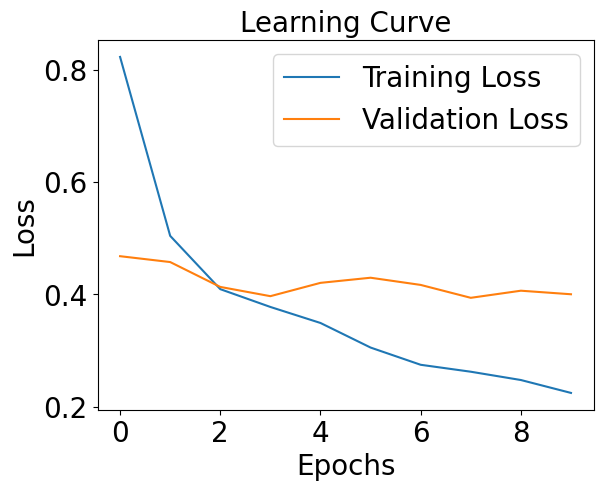

In [43]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

## Creating a Directory for the Figure

In [44]:
figure_dir = '/content/figures'
os.makedirs(figure_dir, exist_ok=True)
plt.savefig(f'{figure_dir}/learning_curve.png')

<Figure size 640x480 with 0 Axes>

## Unfreezing the Pretrained Layers

In [45]:
for layer in base_model.layers:
    layer.trainable = True

## Compiling the Model (After Unfreezing)

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the Model (After Unfreezing)

In [47]:
history_unfreeze = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[checkpoint, early_stopping])

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 140s 511ms/step - accuracy: 0.7154 - loss: 0.8976 - val_accuracy: 0.3996 - val_loss: 2.7415
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 52s 294ms/step - accuracy: 0.8354 - loss: 0.5090 - val_accuracy: 0.2732 - val_loss: 5.7504
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 83s 300ms/step - accuracy: 0.8666 - loss: 0.4047 - val_accuracy: 0.6114 - val_loss: 2.7749
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 51s 288ms/step - accuracy: 0.8971 - loss: 0.3038 - val_accuracy: 0.3046 - val_loss: 4.8245
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 85s 307ms/step - accuracy: 0.9103 - loss: 0.2687 - val_accuracy: 0.5471 - val_loss: 2.4685


## Plotting the Learning Curve (After Unfreezing)

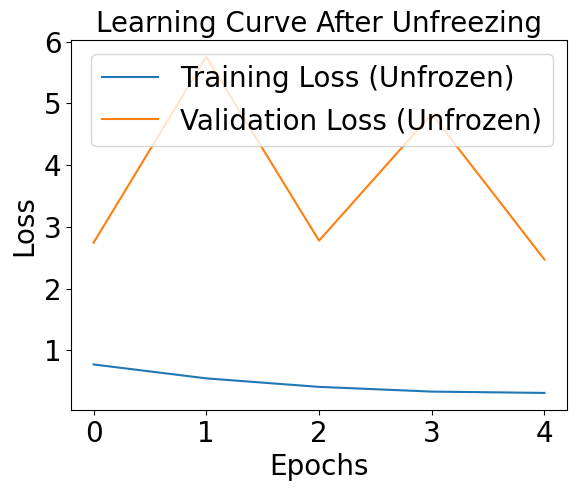

<Figure size 640x480 with 0 Axes>

In [48]:
plt.plot(history_unfreeze.history['loss'], label='Training Loss (Unfrozen)')
plt.plot(history_unfreeze.history['val_loss'], label='Validation Loss (Unfrozen)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve After Unfreezing')
plt.show()

plt.savefig(f'{figure_dir}/learning_curve_unfreeze.png')

## Loading the saved model

## Testing the Model

In [51]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 53s 246ms/step - accuracy: 0.4372 - loss: 2.5274
Test Loss: 2.6829, Test Accuracy: 0.4043
